<a href="https://colab.research.google.com/github/euphoria96/KB_Smishing_dacon/blob/master/Modeling_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setting
### Mounting google drive

In [0]:
from google.colab import drive

drive.mount('/content/gdrive')

### Download Mecab
현재 다양한 자연어 처리 패키지 중에서 mecab는 윈도우에서는 설치가 힘든 패키지 중 하나이다.

이를 극복하기 위해, colab에서 mecab를 설치하고 활용할 수 있도록 colab 파일을 공유하고자 한다.

In [0]:
cd /content/gdrive/My Drive/Colab Notebooks/smishing/Mecab-ko-for-Google-Colab

/content/gdrive/My Drive/Colab Notebooks/smishing/Mecab-ko-for-Google-Colab


In [0]:
! bash install_mecab-ko_on_colab190912.sh

### Import packages

In [0]:
# data preprocessing
import pandas as pd
import numpy as np
import random
from collections import Counter
import matplotlib.pyplot as plt
from tqdm import tqdm # for checking time
import warnings
warnings.filterwarnings(action='ignore') 

### Load Data

In [0]:
cd /content/gdrive/My Drive/Colab Notebooks/smishing/

/content/gdrive/My Drive/Colab Notebooks/smishing


In [0]:
train = pd.read_csv("train.csv")
test = pd.read_csv("public_test.csv")
submission=pd.read_csv("submission_제출양식.csv")
train.shape, test.shape, submission.shape

((295945, 4), (8105, 3), (8105, 2))

In [0]:
train.head()

,id,year_month,text,smishing
0,0,2017-01,XXX은행성산XXX팀장입니다.행복한주말되세요,0
1,1,2017-01,오늘도많이웃으시는하루시작하세요XXX은행 진월동VIP라운지 XXX올림,0
2,2,2017-01,안녕하십니까 고객님. XXX은행입니다.금일 납부하셔야 할 금액은 153600원 입니...,0
3,4,2017-01,XXX 고객님안녕하세요XXX은행 XXX지점입니다지난 한 해 동안 저희 XXX지점에 ...,0
4,5,2017-01,1월은 새로움이 가득XXX입니다.올 한해 더 많이행복한 한해되시길바랍니다,0


총 train data의 행은 약 29만개, test data의 행은 약 8천개로 되어있다.

## Data Preparation
### Sampling
1. Under Sampling : smishing 수에 맞추기
2. Over Sampling : non-smishing 수에 맞추기
3. mixed Sampling : 

In [0]:
Counter(train['smishing'])  # 0.0631975535994864

Counter({0: 277242, 1: 18703})

In [0]:
RANDOM_SEED = 1234

In [0]:
## for train data
# index
train_nsm_idx=list(train[train['smishing']==0].index)
train_sm_idx=list(train[train['smishing']==1].index)
# 3. Mixed Sampling
random.seed(RANDOM_SEED)
train_nsm_idx = random.sample(train_nsm_idx, k=18703*3)
random.seed(RANDOM_SEED)
train_sm_idx = random.choices(train_sm_idx, k=18703*3)

In [0]:
# Merge
train_idx = train_nsm_idx + train_sm_idx
print(train_idx[:5])
random.shuffle(train_idx)
print(train_idx[:5])

[242186, 63505, 4255, 49550, 19561]
[187347, 140625, 240425, 47135, 243703]


In [0]:
# Merge
train_X = pd.DataFrame(train['text'], columns=['text']).iloc[train_idx].reset_index(drop=True)
train_y = pd.DataFrame(train['smishing'], columns=['smishing']).iloc[train_idx].reset_index(drop=True)

In [0]:
## for test data
test['smishing'] = 2 # train data와 동일한 형태 생성을 위해 임의의 숫자를 추가 #이후 스미싱 여부 확률 값으로 덮어 씌워짐
test_X = pd.DataFrame(test['text'])
test_y = pd.DataFrame(test['smishing'])
train_X.shape, train_y.shape, test_X.shape, test_y.shape

((112218, 1), (112218, 1), (8105, 1), (8105, 1))

### Tokenizing

In [0]:
tmp = [len(x) for x in X_train_text]
print('문자최대길이: ',max(tmp))
print('문자평균길이: ',sum(tmp)/len(tmp))

문자최대길이:  1478
문자평균길이:  467.7582027838671


In [0]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [0]:
X_train_text = train_X.text

In [0]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train_text) #5572개의 행을 가진 X의 각 행에 토큰화를 수행
X_train_seq = tokenizer.texts_to_sequences(X_train_text) #단어를 숫자값, 인덱스로 변환하여 저장
word_to_index = tokenizer.word_index

In [0]:
vocab_size = len(word_to_index) + 1
print(vocab_size)

173343


In [0]:
max_len = 500 # 전체 데이터셋의 길이 맞추기
X_train = pad_sequences(X_train_seq, maxlen=max_len)
print("data shape: ", X_train.shape)

data shape:  (112218, 500)


In [0]:
X_test_text = test_X.text

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_test_text) #5572개의 행을 가진 X의 각 행에 토큰화를 수행
X_test_seq = tokenizer.texts_to_sequences(X_test_text) #단어를 숫자값, 인덱스로 변환하여 저장
WordIndex_test = tokenizer.word_index
vocab_size_test = len(word_to_index) + 1

X_test = pad_sequences(X_test_seq, maxlen=max_len)
print("data shape: ", X_test.shape)

data shape:  (8105, 500)


## Modeling

In [0]:
from tensorflow.keras.layers import Embedding, Dense, SimpleRNN, LSTM
from tensorflow.keras.models import Sequential
from sklearn.metrics import roc_auc_score
import tensorflow as tf

In [0]:
def auc_score(y_true, y_pred):
  try:
    auc = roc_auc_score( y_true, y_pred, average='macro', sample_weight=None).astype('float32')
  except ValueError:
    pass
  return auc

In [0]:
def auc( y_true, y_pred ) :
    score = tf.py_func( lambda y_true, y_pred : auc_score(y_true, y_pred) , [y_true, y_pred], 'float32', stateful=False, name='sklearnAUC' )
    return score

### 1. VanillaRNN
##### (a) train

In [0]:
model1 = Sequential()
model1.add(Embedding(vocab_size, 32)) # 임베딩 벡터의 차원은 32
model1.add(SimpleRNN(32)) # RNN 셀의 hidden_size는 32
model1.add(Dense(1, activation='sigmoid'))

model1.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=[auc])
model1.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, None, 32)          5546976   
_________________________________________________________________
simple_rnn_8 (SimpleRNN)     (None, 32)                2080      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 33        
Total params: 5,549,089
Trainable params: 5,549,089
Non-trainable params: 0
_________________________________________________________________


In [0]:
X_train = data

In [0]:
history = model1.fit(X_train, train_y, epochs=5, batch_size=64, validation_split=0.2)

Train on 89774 samples, validate on 22444 samples
Epoch 1/5
89774/89774 [==============================] - 175s 2ms/sample - loss: 0.0226 - auc: 0.9991 - val_loss: 0.0045 - val_auc: 1.0000
Epoch 2/5
89774/89774 [==============================] - 177s 2ms/sample - loss: 0.0026 - auc: 1.0000 - val_loss: 0.0029 - val_auc: 1.0000
Epoch 3/5
89774/89774 [==============================] - 176s 2ms/sample - loss: 0.0012 - auc: 1.0000 - val_loss: 0.0054 - val_auc: 1.0000
Epoch 4/5
89774/89774 [==============================] - 176s 2ms/sample - loss: 0.0012 - auc: 1.0000 - val_loss: 0.0029 - val_auc: 1.0000
Epoch 5/5
89774/89774 [==============================] - 183s 2ms/sample - loss: 9.2640e-04 - auc: 1.0000 - val_loss: 0.0019 - val_auc: 1.0000


##### (b) validation

In [0]:
print("\n 테스트 정확도: %.4f" % (model.evaluate(X_train, train_y)[1]))

112218/112218 [==============================] - 84s 749us/sample - loss: 0.6571 - auc: 0.7376

 테스트 정확도: 0.7376


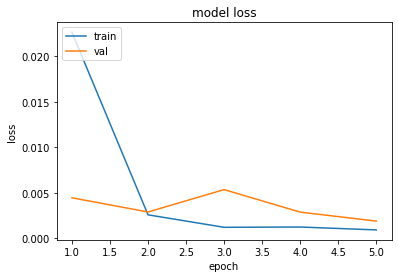

In [0]:
epochs = range(1, len(history.history['auc']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

##### (c) Fit the best one

In [0]:
model1.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=[auc])
history1 = model1.fit(X_train, train_y, epochs=5, batch_size=64, validation_split=0.2)

In [0]:
y_pred_1 = model1.predict(X_test, batch_size=64)
print(y_pred_1.shape)

(8105, 1)


### Submission
test data에서 각 text당 스미싱 확률을 구할 수 있으니 이를 제출양식의 smishing 변수에 넣고 csv 파일로 내보낸다

In [0]:
cd /content/gdrive/My Drive/Colab Notebooks/smishing/submission

/content/gdrive/My Drive/Colab Notebooks/smishing/submission


In [0]:
submission['smishing'] = y_pred_1

submission.to_csv("simpleRNN_1.csv",index=False)